# Aufgabe 44 Analyse von Temperaturdaten

## a) Daten inspizieren

In [1]:
# matplotlib Einstellungen
%config InlineBackend.figure_formats = ['svg','png']
import matplotlib as mpl
mpl.rcParams['font.size'] = 13
mpl.rcParams['figure.figsize'] = (7,5)
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('Temperaturdaten_Dortmund.csv')
df

,Datum,Uhrzeit,Messzeit,Temperatur
0,01.01.2000,00:00,2000.000000,3.0
1,01.01.2000,00:15,2000.000028,3.0
2,01.01.2000,00:30,2000.000057,3.0
3,01.01.2000,00:45,2000.000085,3.0
4,01.01.2000,01:00,2000.000114,3.0
...,...,...,...,...
307885,31.12.2008,23:10,2008.999905,-4.0
307886,31.12.2008,23:20,2008.999924,-3.0
307887,31.12.2008,23:30,2008.999943,-3.0
307888,31.12.2008,23:40,2008.999962,-4.0


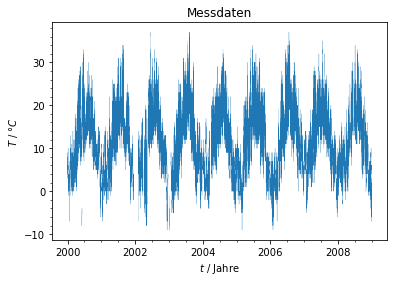

In [4]:
plt.title('Messdaten')
plt.plot(df['Messzeit'],df['Temperatur'], linewidth=0.2)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.show()

In [5]:
df['Messzeit'].diff()

0              NaN
1         0.000028
2         0.000028
3         0.000028
4         0.000028
            ...   
307885    0.000019
307886    0.000019
307887    0.000019
307888    0.000019
307889    0.000019
Name: Messzeit, Length: 307890, dtype: float64

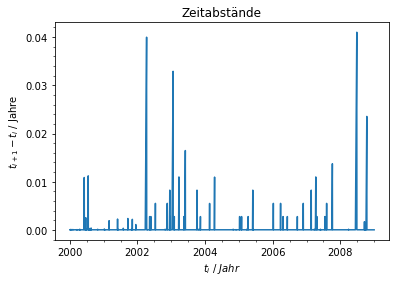

In [6]:
plt.title('Zeitabstände')
plt.plot(df['Messzeit'], df['Messzeit'].diff())
#plt.yscale('log')
plt.xlabel('$t_i$ / $Jahr$')
plt.ylabel('$t_{i+1} - t_i$ / Jahre')
plt.show()

In [7]:
# Anzahl von Fehlenden Werten
df.isnull().sum()

Datum             0
Uhrzeit           0
Messzeit          0
Temperatur    20273
dtype: int64

Fouriertransformation (DFT oder FFT) sind hier nicht ohne Weiteres anwendbar, da die Zeitabstände nicht gleichmäßig sind.  
Gridding wäre möglich, aber ist nicht zu empfehlen, da dadurch die Analyse sehr ungenau wird.  
Ein Lomb-Scargle Periodogram ist anwendbar, wenn die NaN Werte entfernt werden.

## b) Daten für Lomb-Scargle Periodogram vorbereiten

In [8]:
df = df.dropna()

In [9]:
# Anzahl von Fehlenden Werten
df.isnull().sum()

Datum         0
Uhrzeit       0
Messzeit      0
Temperatur    0
dtype: int64

In [10]:
df_ = df

In [11]:
#df = df_[(2001<df['Messzeit'])&(df['Messzeit']<2001.666)]

In [12]:
temp = df['Temperatur'].to_numpy()
time = df['Messzeit'].to_numpy()

In [13]:
temp_mean = np.mean(df_['Temperatur'])
temp_offset = temp - temp_mean

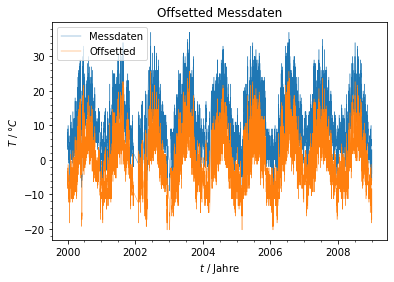

In [14]:
plt.title('Offsetted Messdaten')
plt.plot(time, temp, label='Messdaten', linewidth=0.4)
plt.plot(time, temp_offset, label='Offsetted', linewidth=0.4)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.legend()
plt.show()

## c)
Wenn $\Delta t$ die Zeitdifferenz vom Anfang zum Ende ist und $\delta t$ der Zeitabstand von zwei Messwerten ist, dann:  
Maximale auflösbare Frequenz: $f_{max} = \frac{1}{2\delta t}$  
Minimale auflösbare Frequenz: $f_{min} = \frac{1}{\Delta t}$  

Bzw.:  
Minimale auflösbare Periodendauer: $T_{min} = 2 \delta t$  
Maximale auflösbare Periodendauer: $T_{max} = \Delta t$

Aus Vorwissen sind die zu erwartende Periodizitäten in der Temperatur:  
$f_1 = \frac{1}{\text{Jahr}}$ und $f_2 = \frac{1}{\text{Tag}}$

In [15]:
from scipy.signal import lombscargle

### Jährliche Periodizität

In [16]:
# Frequenzen die zu untersuchen sind
n_freq = 1000
freq = np.linspace(0.01, 2, n_freq)
ang_freq = freq*2*np.pi

In [17]:
pgram = lombscargle(time, temp, ang_freq)
pgram_offset = lombscargle(time, temp_offset, ang_freq)

pgram.shape, pgram_offset.shape

((1000,), (1000,))

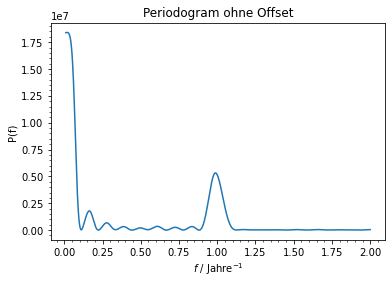

In [18]:
plt.title('Periodogram ohne Offset')
plt.plot(freq, pgram)
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('P(f)')
plt.show()

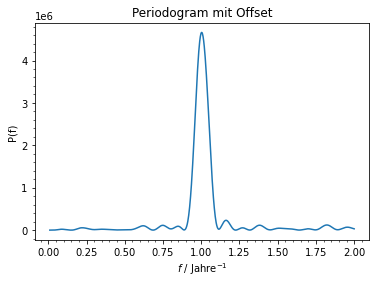

In [19]:
plt.title('Periodogram mit Offset')
plt.plot(freq, pgram_offset)
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('P(f)')
plt.show()

### Tägliche Periodizität

In [20]:
# Frequenzen die zu untersuchen sind
n_freq = 1000
freq = np.linspace(340, 380, n_freq)
ang_freq = freq*2*np.pi

In [21]:
pgram_offset = lombscargle(time, temp_offset, ang_freq)

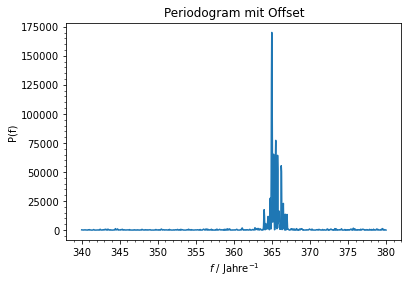

In [22]:
plt.title('Periodogram mit Offset')
plt.plot(freq, pgram_offset)
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('P(f)')
plt.show()

## d) Fouriertransformation

### Gridding

In [23]:
delta_time = 15 # min
mins_per_year = 365 * 24 * 60
delta_time = delta_time / mins_per_year # Jahre
mins_per_year, delta_time

(525600, 2.8538812785388127e-05)

In [24]:
time_gridded = np.arange(np.min(time), np.max(time), delta_time)

In [25]:
from scipy.interpolate import interp1d

temp_gridded = interp1d(time, temp_offset)(time_gridded)

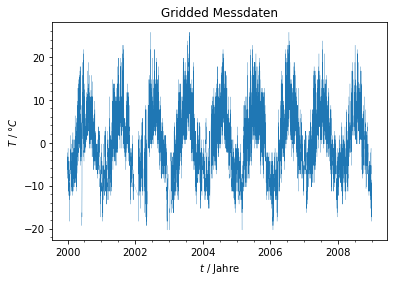

In [26]:
plt.title('Gridded Messdaten')
plt.plot(time_gridded,temp_gridded, linewidth=0.2)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.show()

### Fast Fouriertransformation

In [27]:
from scipy.fft import rfft, rfftfreq

A_gridded = rfft(temp_gridded)
freq_gridded = rfftfreq(n = len(time_gridded), d = delta_time)

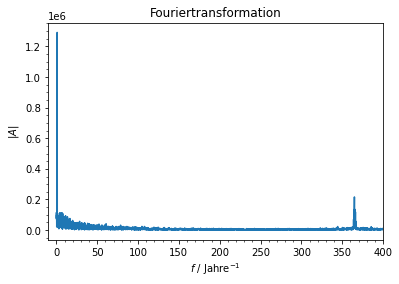

In [28]:
plt.title('Fouriertransformation')
plt.plot(freq_gridded, np.abs(A_gridded))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xlim(-10,400)
plt.show()

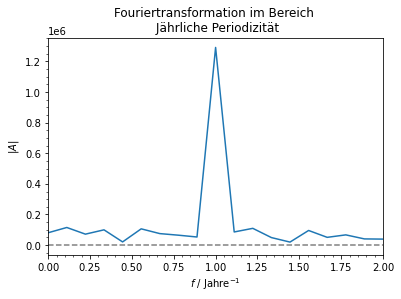

In [29]:
plt.title('Fouriertransformation im Bereich \n Jährliche Periodizität')
plt.axhline(0, color='k', alpha=0.5, linestyle='--')
plt.plot(freq_gridded, np.abs(A_gridded))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xlim(0,2)
plt.show()

In [30]:
phase_1 = np.rad2deg(np.angle(A_gridded[freq_gridded == 1]))[0]
print(f'Phase bei f=1/Jahr: {phase_1}')

Phase bei f=1/Jahr: 161.43297603615653


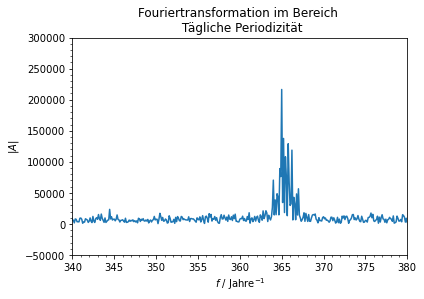

In [31]:
plt.title('Fouriertransformation im Bereich \n Tägliche Periodizität')
plt.plot(freq_gridded, np.abs(A_gridded))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xlim(340,380)
plt.ylim(-0.05*10**6, 0.3*10**6)
plt.show()

### Inverse Transformation

In [32]:
from scipy.fft import irfft

In [77]:
A_threshold = 10**5
A_smoothed = np.copy(A_gridded)
A_smoothed[np.abs(A_gridded) < A_threshold] = 0
temp_smoothed = irfft(A_smoothed)

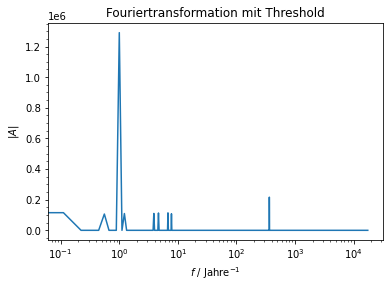

In [78]:
plt.title('Fouriertransformation mit Threshold')
plt.plot(freq_gridded, np.abs(A_smoothed))
plt.xlabel('$f$ / Jahre$^{-1}$')
plt.ylabel('$|A|$')
plt.xscale('log')
plt.show()

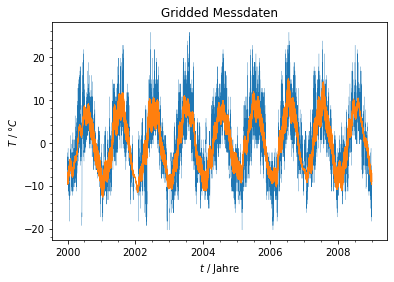

In [82]:
plt.title('Rücktransformation')
plt.plot(time_gridded,temp_gridded, linewidth=0.2)
plt.plot(time_gridded,temp_smoothed, linewidth=0.5)
plt.xlabel('$t$ / Jahre')
plt.ylabel('$T$ / $°C$')
plt.show()

# Aufgabe 45: Kurzfragen zur harmonischen Analyse

## Welche Frequenzen erlaubt das Nyquist-Shannon Abtasttheorem

Wenn eine Funktion $x(t)$ $N$ mal in Abständen $\Delta t$ abgetastet (sampled) wurde, können nur Frequenzen $f < \frac{1}{2\Delta t}$ in den abgetasteten Werten enthalten sein.  

Bei der diskreten Fouriertransformation können somit die Kreisfrequenzen $\omega \in [-\frac{\pi}{\Delta t}, \frac{\pi}{\Delta t}]$ in Abständen $\Delta \omega = \frac{2 \pi}{N \Delta t}$ analysiert werden.  
Also $\omega_n = \frac{2 \pi}{N \Delta t} n$.

## Warum kann Gridding notwendig sein, welches Problem kann auftreten?

Die diskrete Fouriertransformation kann nur verwendet werden, wenn die Messdaten gleichmäßige (Zeit-)Abstände aufweisen.
Gridding erzeugt gleichmäßig verteilte Werte aus ungleichmäßig verteilten Messwerten.

Durch Gridding werden die Messdaten verändert und es werden Frequenzen in die Daten einfließen, die eigentlich in den Messdaten nicht enthalten sind.  
Das führt dazu, dass die Fouriertransformation keine klaren Peaks mehr besitzen, sondern dass die Frequenzen "ausgeschmiert" werden.

## Umreißen Sie kurz die Idee hinter der Fast Fouriertransformation

Die in der DFT auftretende Summe benötigt $O(N^2)$ Operationen um berechnet zu werden.  
Man kann ausnutzen, dass die Fouriertransformation in zwei DFT mit halber Anzahl an Messwerten aufgeteilt werden kann.  
Diese zwei DFTs benötigen allerdings nur ein viertel so viele Operationen wie die ganze DFT.  
Wenn man so die DFTs immer in kleinere DFTs aufteilt kommt man zu einer Laufzeit von $O(N \log N)$ was wesentlich schneller ist als $O(N^2)$.

Vorraussetzung ist, dass die Anzahl der Messpunkte $N = 2^m$ ist.

## Wie unterscheiden sich Fourier-Transformation und Lomb-Scargle Periodogramm?

Die DFT liefert für fest bestimmte Frequenzen die komplexe Amplitude der Fourierreihe, also sowohl Amplitude als auch Phase.
Das Lomb-Scargle Periodogramm liefert für beliebige Frequenzen das geschätzte Betragsquadrat der Amplitude, so als würde ein Least-Squares-Fit mit einer Summe von Sinusfunktionen durchgeführt. Also werden hier keine Phasen bestimmt.

## Was sind die Vorteile der Fourier-Transformation oder der Lomb-Scargle Periodogramme?

Vorteile DFT:
- gibt auch Phasen zurück
- sehr effizient
- kann invertiert werden

Vorteile Lomb-Scargle Periodogramm:
- benötigt nicht (zeitlich) gleichmäßig verteilte Messdaten
- höhere Frequenzauflösung, bzw. beliebige Frequenzen können analysiert werden
- ideal für den Nachweis einer Frequenzkomponente (was soll das bedeuten?)